<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA2024/blob/main/Python/CP3_worked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3

1. Finite Difference solver for the reaction-advection-diffusion problem with nonconstant coefficients:

$-\alpha(x) u''(x)+\beta(x) u'(x)+\gamma(x) u(x)=f(x) \quad \in (a,b)$

$u(a)=0, \quad u(b)=0$.

Implement FD method including the boundary conditions in the system.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

Function computing the 1D FD algebric system

In [13]:
def FD1D(omega,N,alpha,beta,gamma,rhs):
    # FD system matrix and rhs for
    # diffusion-advection-reaction problem with coeffs
    # alpha,beta,gamma,rhs
    # homogeneous Dirichlet bc
    # uniform grid in sparse CSR format

    # grid
    h = (omega[1] - omega[0]) / N
    x = np.linspace(omega[0], omega[1], N + 1)

    # compute coeffs and rhs values
    diff = alpha(x)
    conv = beta(x)
    reac = gamma(x)
    F = rhs(x)

    # assemble system matrix
    diff_term = [-diff[1 : N + 1], 2 * diff, -diff[0 : -1]]
    conv_term = [-conv[1 : N + 1], conv[0 : -1]]

    A = (1./h**2) * sp.diags(diff_term,[-1,0,1],format="csr") + (1. / (2 * h)) * sp.diags(conv_term,[-1,1],format="csr") + sp.diags(reac,0,format="csr")

    # modify system to account for homogeneous Dirichlet boundary conditions
    A[0,0] = 1; A[0,1] = 0; F[0] = 0
    A[N,N] = 1; A[N,N-1] = 0; F[N] = 0

    return A, F

Solve the boundary value problem with:

$a=0,\, b=Π$

$\alpha(x)=1+\sin(x),\,  \beta(x)=1,\, \gamma(x)=x,\, f(x)=1$

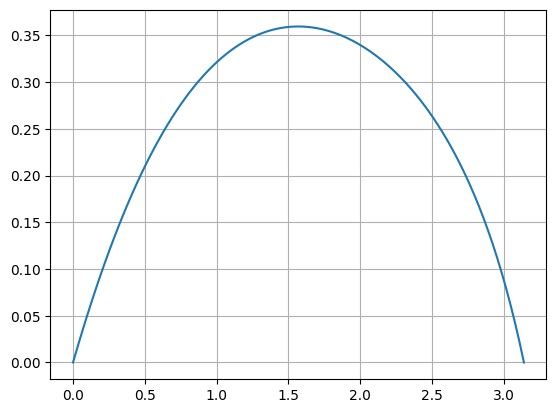

In [15]:
# Problem domain
omega = [0, np.pi]

# Problem data
alpha = lambda x : 1 + np.sin(x)
beta = lambda x : np.ones(len(x))
gamma = lambda x : x
rhs = lambda x : np.ones(len(x))

# Grid parameters
N = 100
x = np.linspace(omega[0],omega[1],N+1)

# Assemble FD system
A, F = FD1D(omega, N, alpha, beta, gamma, rhs)

# solve
uh = sp.linalg.spsolve(A, F)

# plot solution
plt.plot(x,uh)
plt.grid()

Compute experimental order of convergence (EOC) using knowledge that

$|| U-U_h ||_\infty \approx C h^k$

with $C$ independent of $h$. Hence,

$\frac{|| U-U_{h_1} ||_\infty}{|| U-U_{h_2} ||_\infty}\approx\large(\frac{h_1}{h_2}\large)^k$,

and then,

$k\approx\frac{\log || U-U_{h_1} ||_\infty-\log|| U-U_{h_2} ||_\infty}{\log h_1 - \log h_2}$.

Notice that to estimate the EOC you need to run at least two experiments, for instance with $h_1=h$, $h_2=h/2$.

For simplicity, let's take

$\alpha(x)=1,\,  \beta(x)=0,\, \gamma(x)=0$

and

$u=\sin(x)$ so that $f=\sin(x)$


In [16]:
omega = [0, np.pi]

alpha = lambda x : np.ones(len(x))
beta = lambda x : 0. * np.ones(len(x))
gamma = lambda x : 0. * np.ones(len(x))
rhs = lambda x : np.sin(x)
u = lambda x : np.sin(x)

no_exp = 12

N = 4
x = np.linspace(omega[0], omega[1], N + 1)
A, F = FD1D(omega, N, alpha, beta, gamma, rhs)
uh = sp.linalg.spsolve(A, F)
err1 = max(abs(u(x) - uh))
h1 = (omega[1] - omega[0]) / N

for i in range(no_exp - 1):
    N = 2 * N
    x = np.linspace(omega[0], omega[1], N + 1)
    A, F = FD1D(omega, N, alpha, beta, gamma, rhs)

    uh = sp.linalg.spsolve(A, F)
    err2 = max(abs(u(x) - uh))
    h2 = (omega[1] - omega[0]) / N

    print((np.log(err1) - np.log(err2)) / (np.log(h1) - np.log(h2)))

    err1 = err2
    h1 = h2

2.0337540817563418
2.0083667395265783
2.002087242818026
2.000521533808191
2.0001303666095027
2.000032593400208
2.0000081986611353
2.0000026435322216
2.000007765525166
2.0000708399864684
1.9995484754935031


What if the exact solution is not known? Then we can still estimate the EOC using three experiments. Indeed, letting $h_2=\theta h_1$, we have

$|| U_{h_2}-U_{h_1} ||_\infty\le || U-U_{h_1} ||_\infty + || U-U_{h_2} ||_\infty\approx C h_1^k+C h_2^k \approx C (1+\theta^k) h_1^k$

Now, given also $h_3 = \theta h_2$, we have similarly

$|| U_{h_3}-U_{h_2} ||_\infty \approx C (1+\theta^k) h_2^k=C (1+\theta^k)\theta^k h_1^k$

hence,

$\frac{|| U_{h_2}-U_{h_1} ||_\infty}{|| U_{h_3}-U_{h_2} ||_\infty}\approx \frac{C (1+\theta^k) h_1^k}{C (1+\theta^k)\theta^k h_1^k}=\theta^{-k}$

from which $k$ can be estimated as before by passing to the logs.

NOTE! The discrete solutions are defined at different sets of points so the above comparison is to be intended on the set of common points!

**Exercise 1:** try this out for the problem with

$\alpha(x)=1+\sin(x),\,  \beta(x)=1,\, \gamma(x)=x, \, f=1$.

Check that you still get the expected rate of convergence.

In [17]:
omega = [0, np.pi]

x = np.linspace(omega[0], omega[1], N + 1)
A, F = FD1D(omega, N, alpha, beta, gamma, rhs)
uh = sp.linalg.spsolve(A, F)
err1 = max(abs(u(x) - uh))
h1 = (omega[1] - omega[0]) / N

alpha = lambda x : np.ones(len(x)) + np.sin(x)
beta = lambda x : np.ones(len(x))
gamma = lambda x : x
rhs = lambda x : np.ones(len(x))

theta = 0.5

uh_prev = None
err_prev = None

for N in [2**i for i in range(2,16)]:
    x = np.linspace(omega[0], omega[1], N + 1)
    A, F = FD1D(omega, N, alpha, beta, gamma, rhs)
    uh = sp.linalg.spsolve(A, F)

    if uh_prev is not None:
        err = max(abs(uh[::2] - uh_prev))
        if err_prev is not None:
            k = np.log(err / err_prev) / np.log(theta)
            print(f'Estimated EOC: {np.around(k, 3)} (N = {N})')

        err_prev = err

    uh_prev = uh

Estimated EOC: 1.755 (N = 16)
Estimated EOC: 1.859 (N = 32)
Estimated EOC: 1.971 (N = 64)
Estimated EOC: 1.99 (N = 128)
Estimated EOC: 1.998 (N = 256)
Estimated EOC: 1.999 (N = 512)
Estimated EOC: 2.0 (N = 1024)
Estimated EOC: 2.0 (N = 2048)
Estimated EOC: 2.0 (N = 4096)
Estimated EOC: 2.0 (N = 8192)
Estimated EOC: 1.999 (N = 16384)
Estimated EOC: 2.009 (N = 32768)


## Exercise 2

Modify the FD1D routine to solve problems with nonhomogeneous boundary conditions.

In [18]:
def FD1D_NH(omega, N, alpha, beta, gamma, rhs, bc_left, bc_right):
    h = (omega[1]-omega[0])/N
    x = np.linspace(omega[0], omega[1], N+1)

    diff = alpha(x)
    conv = beta(x)
    reac = gamma(x)
    F = rhs(x)

    diff_term = [-diff[1:N+1], 2*diff, -diff[0:-1]]
    conv_term = [-conv[1:N+1], conv[0:-1]]

    A = (1./h**2) * sp.diags(diff_term,[-1,0,1],format="csr")+(1./(2*h)) * sp.diags(conv_term,[-1,1],format="csr") + sp.diags(reac,0,format="csr")

    A[0,0] = 1; A[0,1] = 0; F[0] = bc_left
    A[N,N] = 1; A[N,N-1] = 0; F[N] = bc_right

    return A, F

In [19]:
uh_prev = None
err_prev = None

for N in [2**i for i in range(2,16)]:
    x = np.linspace(omega[0], omega[1], N + 1)
    A, F = FD1D_NH(omega, N, alpha, beta, gamma, rhs, 0.0, 0.0)
    uh = sp.linalg.spsolve(A, F)

    if uh_prev is not None:
        err = max(abs(uh[::2] - uh_prev))
        if err_prev is not None:
            k = np.log(err / err_prev) / np.log(theta)
            print(f'Estimated EOC: {np.around(k, 4)} (N = {N})')

        err_prev = err

    uh_prev = uh

Estimated EOC: 1.7552 (N = 16)
Estimated EOC: 1.8589 (N = 32)
Estimated EOC: 1.9706 (N = 64)
Estimated EOC: 1.9902 (N = 128)
Estimated EOC: 1.9982 (N = 256)
Estimated EOC: 1.9993 (N = 512)
Estimated EOC: 1.9999 (N = 1024)
Estimated EOC: 2.0 (N = 2048)
Estimated EOC: 2.0 (N = 4096)
Estimated EOC: 2.0001 (N = 8192)
Estimated EOC: 1.9989 (N = 16384)
Estimated EOC: 2.0085 (N = 32768)


## Exercise 3

Consider now the problem defined by:

$a=0$, $b=1$, $u(0)=1$, $u(1)=0$ $f=0$ and

$\alpha=\beta=\gamma=1$.

Solve this problem using a grid made of $N=10$ intervals and plot the solution.

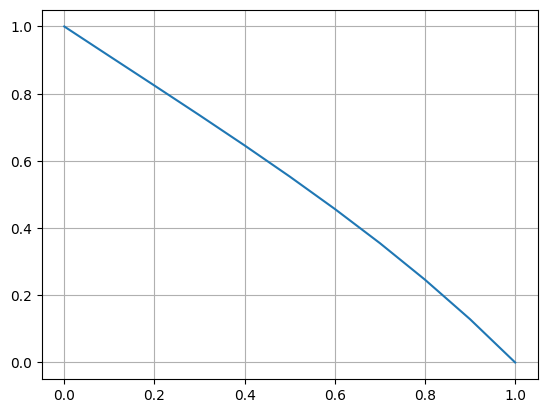

In [20]:
omega = [0., 1.]
alpha = lambda x : np.ones(len(x))
beta = lambda x : np.ones(len(x))
gamma = lambda x : np.ones(len(x))
rhs = lambda x : 0. * np.ones(len(x))
N = 10

A, F = FD1D_NH(omega, N, alpha, beta, gamma, rhs, 1., 0.)
x = np.linspace(omega[0], omega[1], N + 1)
uh = sp.linalg.spsolve(A, F)
plt.plot(x,uh)
plt.grid()

Next, try with $\alpha=0.01$, $\beta=1$, $\gamma=0$. What happens? Can you explain? Experiment by taking finer grids.

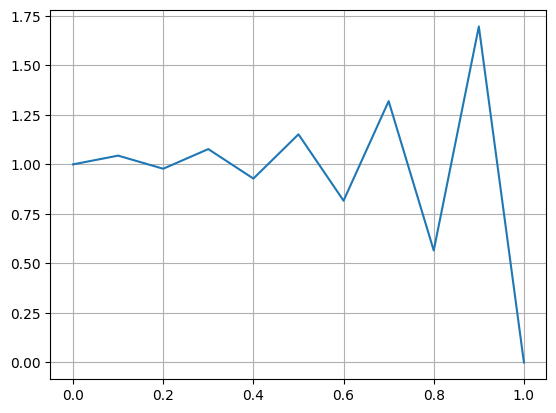

In [21]:
alpha = lambda x : 0.01 * np.ones(len(x))
beta = lambda x : np.ones(len(x))
gamma = lambda x : 0 * np.ones(len(x))

A, F = FD1D_NH(omega, N, alpha, beta, gamma, rhs, 1., 0.)
x = np.linspace(omega[0], omega[1], N + 1)
uh = sp.linalg.spsolve(A, F)
plt.plot(x,uh)
plt.grid()

In the first case there is a high diffusion coefficient ($\alpha=1$) and a non-zero reaction term ($\gamma=1$). This leads to a diffusion-dominated problem, where the solution tends to be smooth. The high diffusion spreads the effect of the boundary conditions smoothly across the domain.

In the second case there is a low diffusion coefficient ($\alpha=0.01$) and a zero reaction term ($\gamma=0$). This leads to a convection-dominated problem, where the solution can exhibit steep gradients or oscillations.

One way to mitigate this is to use a more sophisticated numerical method that can handle convection-dominated problems better, such as upwind schemes, stabilization techniques, or adaptive mesh refinement.